In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import math
from collections import deque
import pickle

In [94]:
bitstamp = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
bitstamp.drop(labels='Timestamp', axis=1, inplace=True)
bitstamp = bitstamp[2500000:]
bitstamp.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2500000,609.87,609.87,609.41,609.41,4.200000,2560.068344,609.540082
2500001,609.87,609.87,609.41,609.41,4.200000,2560.068344,609.540082
2500002,609.87,609.87,609.41,609.41,4.200000,2560.068344,609.540082
2500003,610.97,610.97,610.97,610.97,0.018135,11.080002,610.970000
2500004,610.97,610.97,610.97,610.97,0.018135,11.080002,610.970000


In [58]:
bitstamp.shape

(905857, 7)

In [9]:
bitstamp[bitstamp.Close-bitstamp.Open>0].shape

(365123, 7)

In [59]:
bitstamp = np.array(bitstamp)

In [60]:
bitstamp

array([[  6.09870000e+02,   6.09870000e+02,   6.09410000e+02, ...,
          4.20000000e+00,   2.56006834e+03,   6.09540082e+02],
       [  6.09870000e+02,   6.09870000e+02,   6.09410000e+02, ...,
          4.20000000e+00,   2.56006834e+03,   6.09540082e+02],
       [  6.09870000e+02,   6.09870000e+02,   6.09410000e+02, ...,
          4.20000000e+00,   2.56006834e+03,   6.09540082e+02],
       ..., 
       [  6.07915000e+03,   6.08553000e+03,   6.07010000e+03, ...,
          5.17498402e+00,   3.14474231e+04,   6.07681550e+03],
       [  6.08221000e+03,   6.08686000e+03,   6.06800000e+03, ...,
          1.44823012e+01,   8.80003803e+04,   6.07640864e+03],
       [  6.07399000e+03,   6.07541000e+03,   6.06456000e+03, ...,
          2.35110041e+01,   1.42706804e+05,   6.06978771e+03]])

In [28]:
bitstamp.shape

(905857, 7)

In [ ]:
import tensorflow.keras as k

In [33]:
from tensorflow.keras.models import model_from_json

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
class Trader:
    def __init__(self, max_turns=60*24, fee_rate=.0005):
        self.action_space = [i for i in range(17)]
        self.max_turns = max_turns
        self.fee_rate = fee_rate
        self.reset()
        
    def reset(self):
        self.t = 0
        self.cash = 100000
        self.coins = 0
        self.time = random.randrange(60*24*60, len(bitstamp) - 60*24*60)
        self.done = False
        s = self.t+self.time, self.coins, self.cash
        return s

    def step(self, action):
        if self.t == self.max_turns:
            self.done = True
        price_open = bitstamp[self.time + self.t][0]
        price_close = bitstamp[self.time + self.t + 1][0]
        prev_asset = price_open * self.coins + self.cash
        percent = action-8
        if percent < 0:
            coins_sold = self.coins * (-percent) * .1
            self.cash += coins_sold * price_open * (1-self.fee_rate)
            self.coins -= coins_sold

        elif percent > 0:
            money_spent = self.cash * percent * .1 
            self.coins += money_spent * (1-self.fee_rate) / price_open
            self.cash -= money_spent
            
        r = price_close * self.coins + self.cash - prev_asset
        s = self.t+self.time, self.coins, self.cash
        self.asset = price_close * self.coins + self.cash
        if self.asset < 60000:
            self.done = True
            
        self.t += 1
        return s, r, self.done

In [ ]:
class DQNTrader():
    def __init__(self, n_episodes=100, n_win_ticks=195, 
                 gamma=.9999, epsilon=1.0, epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, 
                 batch_size=64):
        self.env = Trader()
        self.memory = deque(maxlen=100000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size

        tf.reset_default_graph()
        
        inputs = Input(shape=(60*24*30*7+2,))
        print(inputs)
        t0 = Lambda(lambda i:i[:,:-2])(inputs)
        c = Lambda(lambda i:i[:,-2:])(inputs)
        t = Reshape((60*24*30,7))(t0)
        print(t,c)
        lstm = CuDNNLSTM(7, return_sequences=False)(t)
        print(lstm)
        h1 = Dense(1)(lstm)
        print(h1,c)
        outputs = Dense(len(self.env.action_space), 'relu')(k.layers.concatenate([h1, c],1))
        print(outputs)
        self.model = k.models.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='Adam', loss='mse')                               
        print(self.model.summary())
        
    def preprocess_state(self, s):
        time, coins, cash = s
        unzip = np.append(bitstamp[time-60*24*30 : time].flatten(), [coins, cash])
        state = unzip.reshape(1,60*24*30*7+2) # 1 batch of input
        return state                                                        
    def choose_action(self, state, epsilon, e):
        state = self.preprocess_state(state)
        return random.choice(self.env.action_space) if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state)[0])

    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        xs, ys = [],[]
        for state, action, reward, next_state, done in minibatch:
            state = self.preprocess_state(state)
            next_state = self.preprocess_state(next_state)
            if done:
                target = reward
            else:
                target = reward + self.gamma * np.max(self.model.predict(next_state)[0])
            Q = self.model.predict(state)
            Q[0][action] = target
            xs.append(state[0])
            ys.append(Q[0])
            if len(xs)%10==0:
                print(len(xs),'/',self.batch_size,'batches loaded')
        self.model.fit(np.array(xs), np.array(ys), epochs=1)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)
        for e in range(self.n_episodes):
            state = self.env.reset()
            done = False
            rewards = 0
            t=0
            print('playing')
            while not done:
                if t%100==0:
                    print(t,'turns played')
                action = self.choose_action(state, self.get_epsilon(e), e)
                next_state, reward, done = self.env.step(action)
                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                rewards += reward   
                t += 1
            
            print(self.env.time, self.env.t, self.env.cash, self.env.coins, self.env.asset)
            scores.append(rewards)
            mean_score = np.mean(scores)
            print('[Episode {}] - Mean score over last 100 episodes was {} ticks.'.format(e, mean_score))
            print('replaying')
            self.replay(self.batch_size)
            json_string = self.model.to_json()
            print('json:',json_string)
            with open('model','w') as f:
                f.write(json_string)
        return e

agent = DQNTrader()
agent.run()

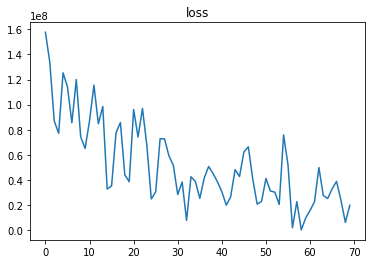

In [30]:
plt.plot(loss)
plt.title('loss')

In [85]:
with open('test.out') as f:
    asset_log=[]
    rewards_log=[]
    for line in f.readlines():
        asset, rewards = list(map(float, line.split()))
        asset_log.append(asset)
        rewards_log.append(rewards)

In [96]:
b=np.array(bitstamp)

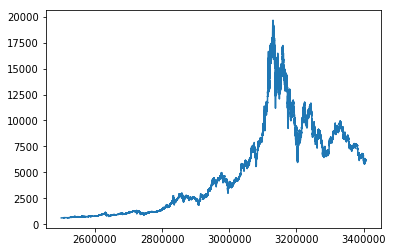

In [98]:
bitstamp.Weighted_Price.plot()

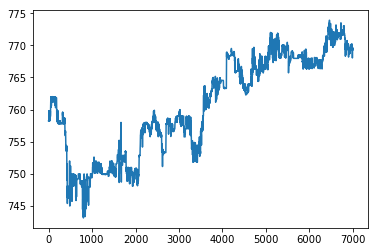

In [99]:
plt.plot(b[60*24*60:60*24*60+7000,6])

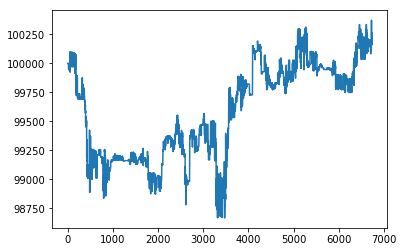

In [101]:
plt.plot(asset_log, label='agent asset')

In [109]:
prices=b[60*24*60:60*24*60+7000,6]

In [110]:
prices = (prices-prices.mean())/prices.std()

In [111]:
prices.mean()

9.7445860904242312e-15

In [105]:
assets=np.array(asset_log)

In [107]:
assets=(assets-assets.mean())/assets.std()

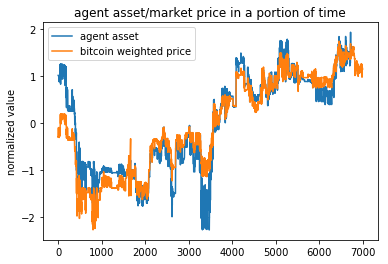

In [113]:
plt.plot(assets, label='agent asset')
plt.plot(prices, label='bitcoin weighted price')
plt.ylabel('normalized value')
plt.xlabel('minutes')
plt.legend()
plt.title('agent asset/market price in a portion of time')

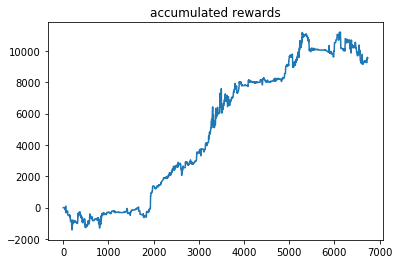

In [89]:
plt.plot(rewards_log)
plt.title('accumulated rewards')